# Imports

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from pathlib import Path
from skimage import color  # type: ignore
from PIL import Image
from torchvision.models import efficientnet_b7

# Dataset

In [13]:
class Places365Train(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root / "train"
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white and lab color space.

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and lab color space image
        """
        with Image.open(self.data_paths[idx]) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)

        lab_img = transforms.ToTensor()(
            color.rgb2lab(rgb_img.permute(1, 2, 0))
        )  # (3, 256, 256) -> L, a, b
        lab_img[0] = lab_img[0] / 100  # L channel
        lab_img[1:] = (lab_img[1:] + 128) / 255  # a, b channel

        return bw_img, lab_img

    @staticmethod
    def lab_to_rgb(lab_img: torch.Tensor) -> torch.Tensor:
        """Convert lab image to rgb image.

        Args:
            lab_img (torch.Tensor): Lab color space image

        Returns:
            torch.Tensor: RGB image
        """
        lab_img[0] = lab_img[0] * 100  # L channel
        lab_img[1:] = (lab_img[1:] * 255) - 128  # a, b channel
        rgb_img = color.lab2rgb(lab_img.permute(1, 2, 0))
        return transforms.ToTensor()(rgb_img)

In [14]:
dataset = Places365Train(Path("/home/salkhon/repo/colorization/data"))

In [26]:
print(len(dataset))

1803460


In [15]:
# print the luminance channel
print(dataset[0][0][0])
print(dataset[0][1][0])

tensor([[0.3490, 0.3490, 0.3529,  ..., 0.4118, 0.4118, 0.4118],
        [0.3490, 0.3490, 0.3529,  ..., 0.4118, 0.4118, 0.4118],
        [0.3451, 0.3490, 0.3490,  ..., 0.4118, 0.4118, 0.4118],
        ...,
        [0.2588, 0.2667, 0.2667,  ..., 0.1373, 0.1294, 0.1176],
        [0.2588, 0.2627, 0.2667,  ..., 0.1412, 0.1294, 0.1216],
        [0.2588, 0.2627, 0.2627,  ..., 0.1451, 0.1333, 0.1255]])
tensor([[0.3754, 0.3754, 0.3795,  ..., 0.4404, 0.4404, 0.4404],
        [0.3754, 0.3754, 0.3795,  ..., 0.4404, 0.4404, 0.4404],
        [0.3712, 0.3754, 0.3754,  ..., 0.4404, 0.4404, 0.4404],
        ...,
        [0.2812, 0.2899, 0.2899,  ..., 0.1373, 0.1279, 0.1149],
        [0.2820, 0.2852, 0.2895,  ..., 0.1423, 0.1279, 0.1184],
        [0.2817, 0.2879, 0.2879,  ..., 0.1469, 0.1330, 0.1232]])


Showing 16 samples from training set torch.Size([16, 1, 256, 256]) torch.Size([16, 3, 256, 256])


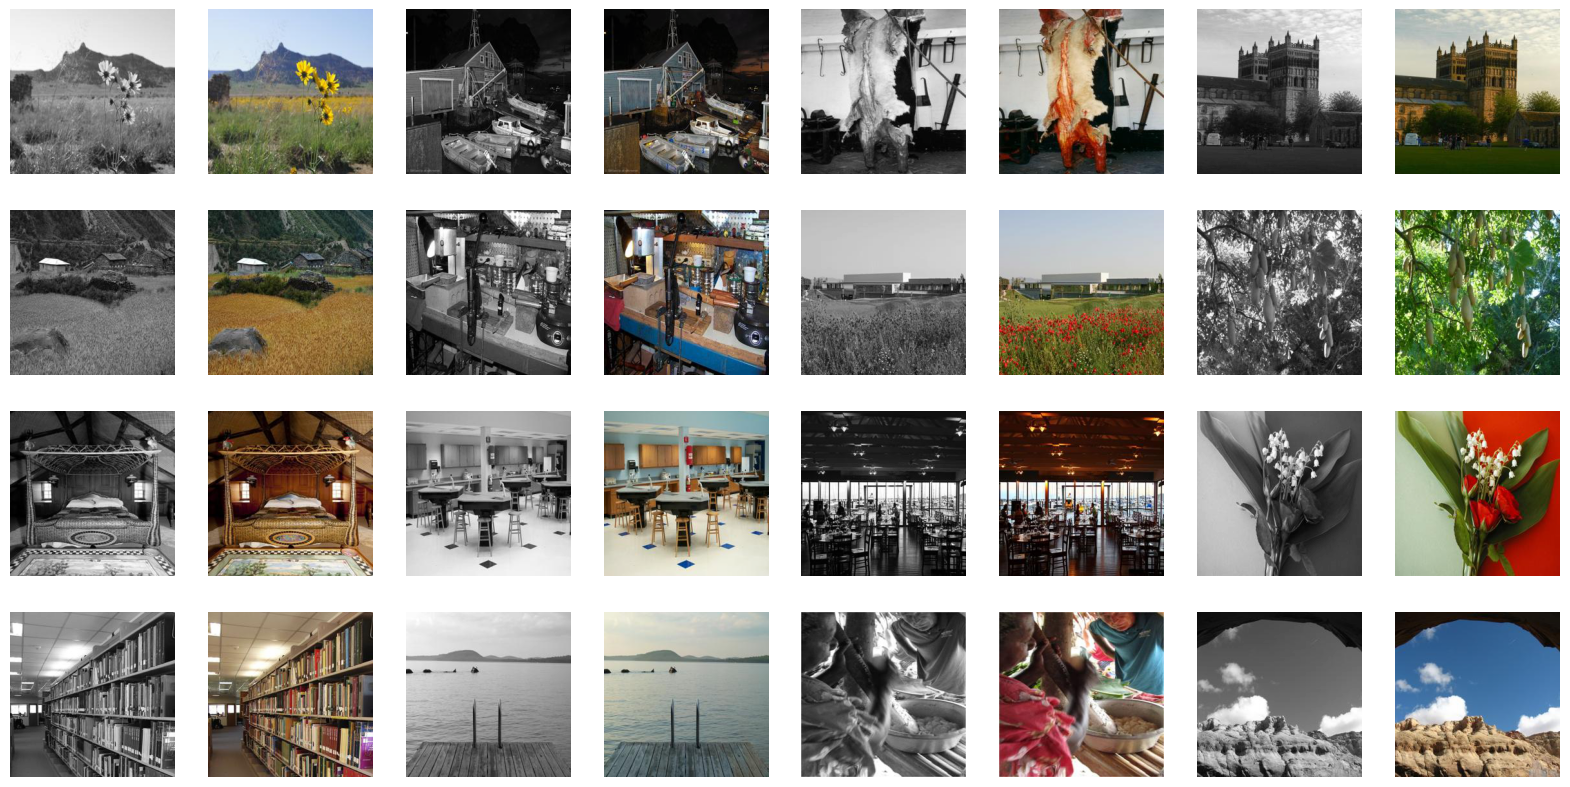

In [25]:
import matplotlib.pyplot as plt

random_sampler = RandomSampler(dataset, num_samples=16)
random_loader = DataLoader(dataset, batch_size=16, sampler=random_sampler)
plt.figure(figsize=(20, 10))
for x, y in random_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(torch.squeeze(x[i]), cmap="gray")
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(Places365Train.lab_to_rgb(y[i]).permute(1, 2, 0))
        plt.axis("off")

Some images are b/w in RGB too

# Model

In [ ]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.feature_extractor = efficientnet_b7(
            pretrained=True, in_channels=3
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            torch.nn.Conv2d(2560, 1024, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(512, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 2, kernel_size=3, padding=1),
            torch.nn.Upsample(scale_factor=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        return self.colorization_layers(features)